In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy import stats

In [88]:
# Load the dataset
df = pd.read_csv("/Trait_Extraction/Results_CSV/height_df.csv")  # Replace with your file path 
df['timestamp'] = df['timestamp'].str.replace('_', ':')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
height_columns = [col for col in df.columns if col.startswith('height_')]

def clean(data_column, alpha=0.1):
    return data_column.ewm(alpha=alpha, adjust=False).mean()

alpha = 0.1
data = pd.DataFrame({'timestamp': df['timestamp']})

for col in height_columns:
    if col in df.columns:  # Ensure column exists
        data[col] = clean(df[col], alpha=alpha)

data.set_index('timestamp', inplace=True)

# Define the REX and ROUXAI columns
rex_height_samples = [f'height_{i}' for i in range(0, 20)]   # height_0 to height_19
rouxai_height_samples = [f'height_{i}' for i in range(20, 40)]   # height_20 to height_39

# Calculate the day number from the timestamp
data['day'] = (data.index - data.index[0]).days

# Adjust the growth stages based on 18 days
def assign_stage(day):
    if day <= 4:
        return 'Seedling'  # Days 0-4
    elif day <= 9:
        return 'Cupping'   # Days 5-9
    elif day <= 13:
        return 'Rosette'   # Days 10-13
    else:
        return 'Heading'   # Days 14-18

data['stage'] = data['day'].apply(assign_stage)

def plot_growth_rate_by_stage(cultivar_samples, cultivar_name, save_path_prefix, color):
    stages = ['Seedling', 'Cupping', 'Rosette', 'Heading']
    
    title_font = {'fontname': 'Times New Roman', 'weight': 'bold', 'size': 19}
    label_font = {'fontname': 'Times New Roman', 'weight': 'bold', 'size': 17}
    tick_font_size = 15
    legend_font_size = 15

    for stage in stages:
        fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size as needed

        # Filter data for the current stage
        data_stage = data[data['stage'] == stage]

        if data_stage.empty:
            print(f"No data available for {cultivar_name} during the {stage} stage.")
            plt.close(fig)
            continue

        # Prepare the data for the current cultivar
        df_samples = data_stage[cultivar_samples]
        df_mean = df_samples.mean(axis=1).to_frame(name='height')
        df_mean.dropna(subset=['height'], inplace=True)

        if df_mean.empty:
            print(f"No height data available for {cultivar_name} during the {stage} stage.")
            plt.close(fig)
            continue

        df_resampled = df_mean.resample('20min').mean()
        df_resampled['height_diff'] = df_resampled['height'].diff()
        df_resampled['time_diff'] = df_resampled.index.to_series().diff().dt.total_seconds() / 3600  
        df_resampled['growth_rate'] = df_resampled['height_diff'] / df_resampled['time_diff']
        df_resampled.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_resampled.dropna(subset=['growth_rate'], inplace=True)

        # Remove outliers using the IQR method
        if len(df_resampled['growth_rate']) > 2:
            Q1 = df_resampled['growth_rate'].quantile(0.25)
            Q3 = df_resampled['growth_rate'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_resampled = df_resampled[
                (df_resampled['growth_rate'] >= lower_bound) & (df_resampled['growth_rate'] <= upper_bound)
            ]

        if df_resampled.empty:
            print(f"No growth rate data available for {cultivar_name} during the {stage} stage after outlier removal.")
            plt.close(fig)
            continue

        df_resampled['growth_rate'] = df_resampled['growth_rate'].apply(lambda x: x if x > 0 else -x)
        df_resampled['hour'] = df_resampled.index.hour
        hourly_stats = df_resampled.groupby('hour')['growth_rate'].agg(['mean', 'std'])
        hourly_stats = hourly_stats.reindex(range(24))
        hourly_stats[['mean', 'std']] = hourly_stats[['mean', 'std']].ffill().bfill()


        if hourly_stats.dropna(subset=['mean']).empty:
            print(f"No hourly growth rate data available for {cultivar_name} during the {stage} stage.")
            plt.close(fig)
            continue

        window_length = min(7, len(hourly_stats))
        if window_length % 2 == 0: 
            window_length -= 1
        if window_length >= 3:
            hourly_stats['mean_smooth'] = savgol_filter(hourly_stats['mean'], 
                                                        window_length=window_length, 
                                                        polyorder=2)
        else:
            hourly_stats['mean_smooth'] = hourly_stats['mean']

        # Ensure that 'std' is not NaN
        hourly_stats['std'] = hourly_stats['std'].fillna(0)

        # Compute upper/lower bounds for shading
        lower_bound = hourly_stats['mean_smooth'] - hourly_stats['std']
        lower_bound = lower_bound.clip(lower=0) 
        upper_bound = hourly_stats['mean_smooth'] + hourly_stats['std']
        y_min = max(lower_bound.min() * 0.9, 0)
        y_max = upper_bound.max() * 1.1

        ax.plot(hourly_stats.index, hourly_stats['mean_smooth'], color=color, linewidth=2, marker='o', label='Growth Rate')
        ax.fill_between(hourly_stats.index, lower_bound, upper_bound, alpha=0.3, color=color)
        ax.set_title(f'{cultivar_name} Lettuce - {stage} Stage', **title_font)
        ax.set_xlabel('Hour of Day', **label_font)
        ax.set_ylabel('Height (cm/hour)', **label_font)
        ax.set_xticks(range(0, 24))
        ax.set_xlim(0, 23)
        ax.tick_params(axis='x', labelsize=tick_font_size, width=1.5)
        ax.tick_params(axis='y', labelsize=tick_font_size, width=1.5)

        for tick in ax.get_xticklabels():
            tick.set_fontname('Times New Roman')
            tick.set_fontweight('bold')
            tick.set_fontsize(tick_font_size)
        for tick in ax.get_yticklabels():
            tick.set_fontname('Times New Roman')
            tick.set_fontweight('bold')
            tick.set_fontsize(tick_font_size)

        ax.set_ylim(bottom=y_min, top=y_max)
        ax.grid(False)

        legend = ax.legend(loc='best', fontsize=legend_font_size, frameon=False)
        for text in legend.get_texts():
            text.set_fontname('Times New Roman')
            text.set_fontweight('bold')
            text.set_fontsize(legend_font_size)

        plt.tight_layout()
        plt.savefig(f'{save_path_prefix}_{cultivar_name}_{stage}_stage.png', format='png', dpi=600)
        plt.show()
        plt.close(fig)

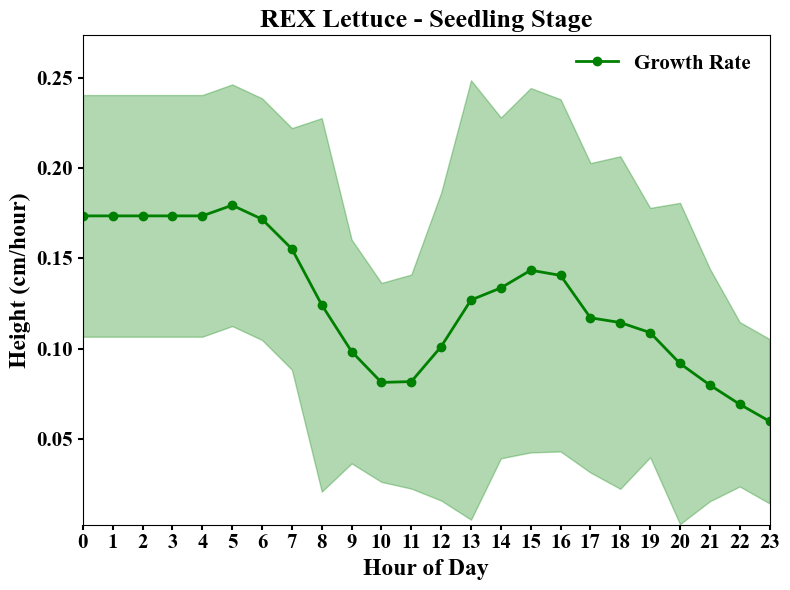

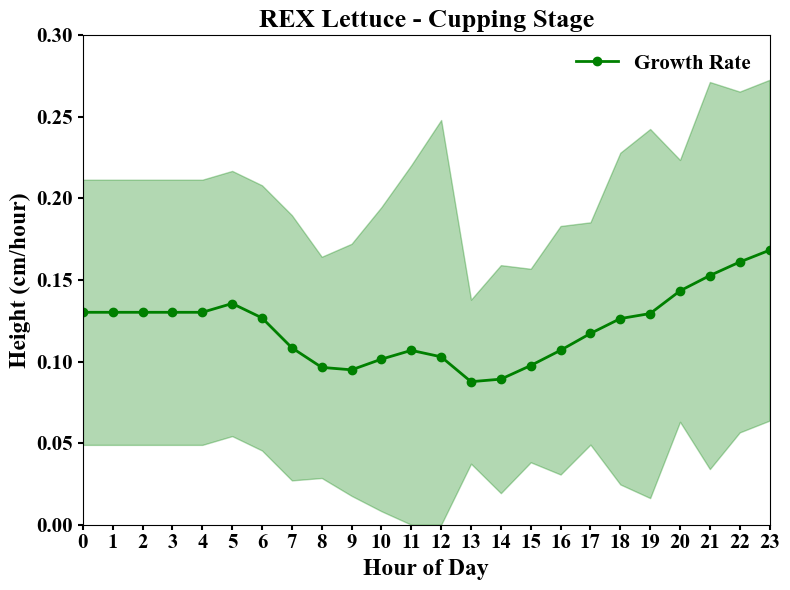

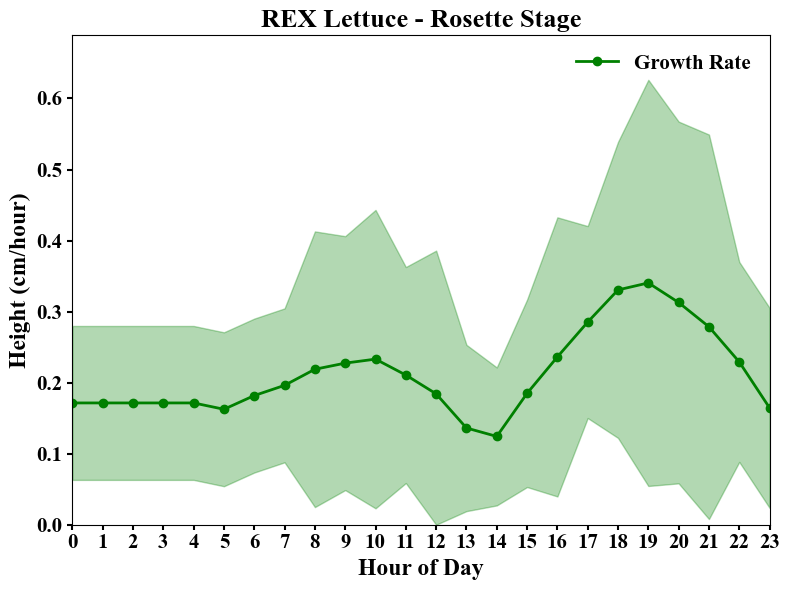

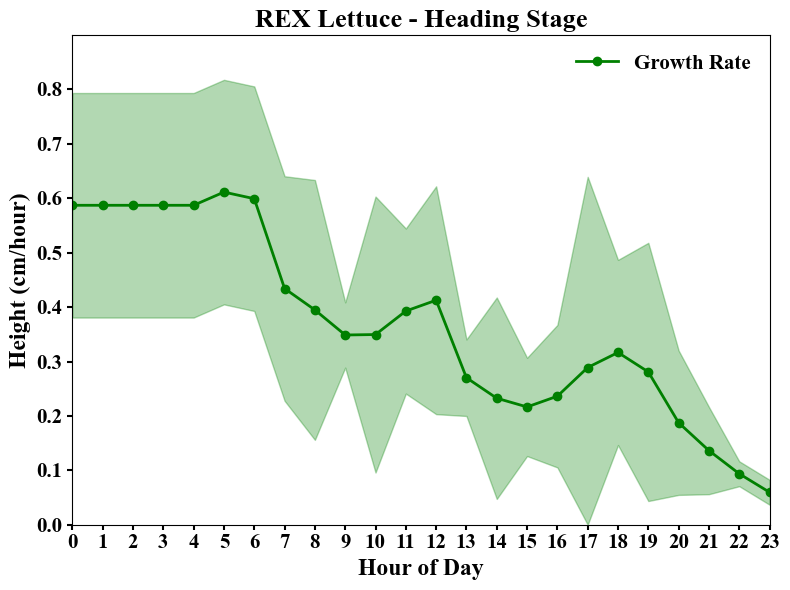

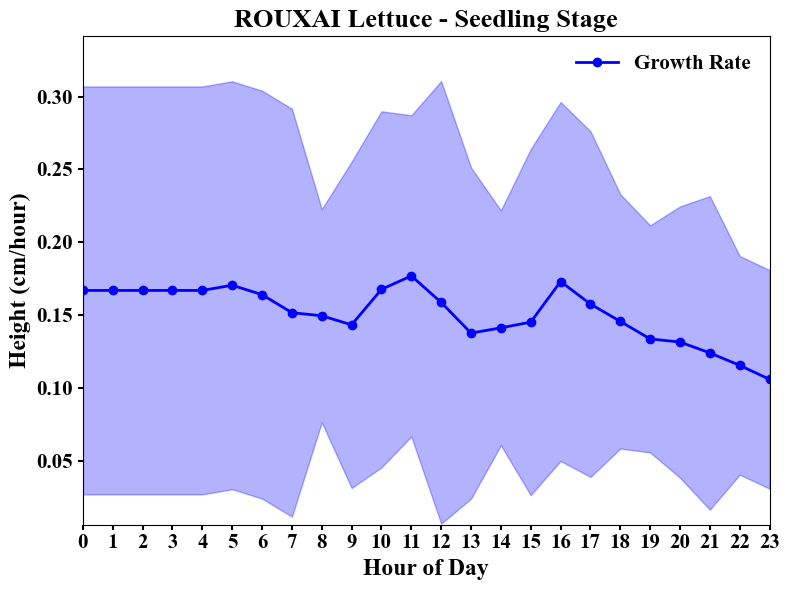

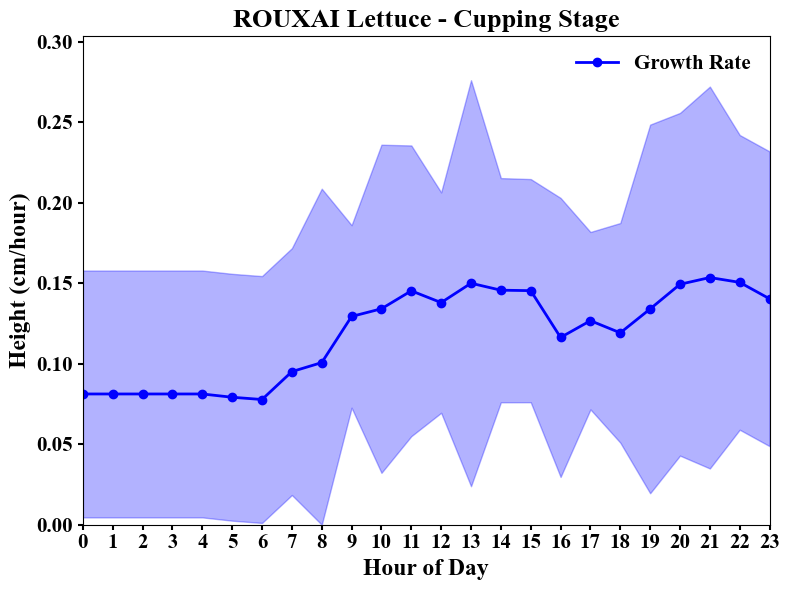

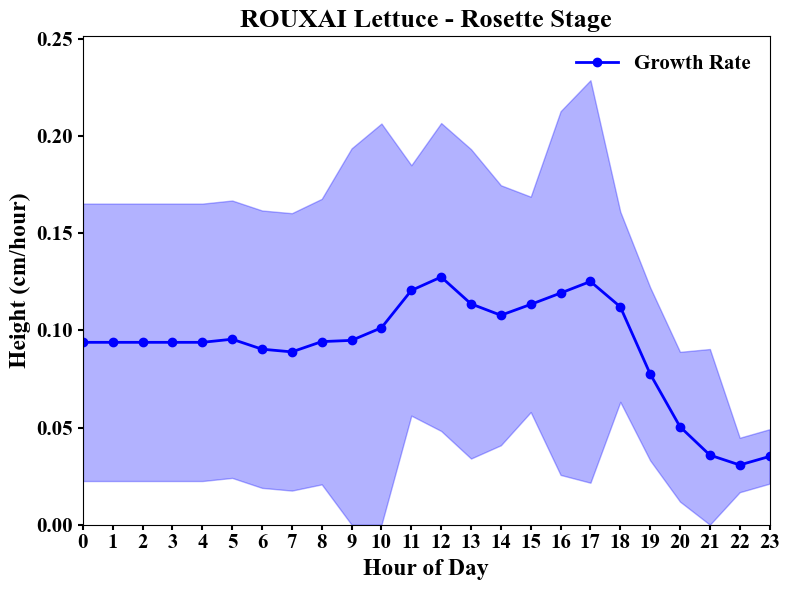

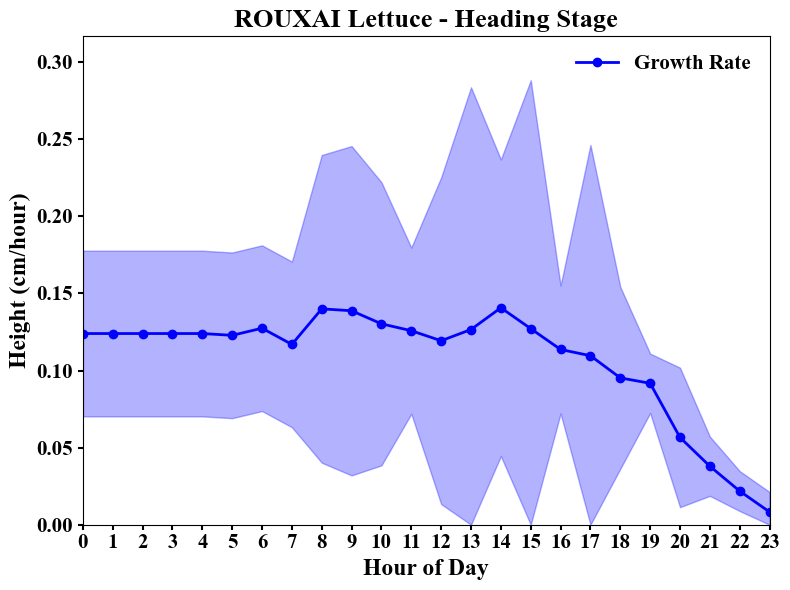

In [89]:
# Example usage:
# Plot for REX cultivar
plot_growth_rate_by_stage(rex_height_samples, 'REX', 'height_growth_rate_plot', color='green')

# Plot for ROUXAI cultivar
plot_growth_rate_by_stage(rouxai_height_samples, 'ROUXAI', 'height_growth_rate_plot', color='blue')